# Condition Monitoring of Bearing vibration data collected under time-varying rotational speed conditions

Just in case Bonfiglioli does not allow me to use their data for my master thesis, I will test the complex-valued models and algorithms developed up to now over another, similar, dataset.

## Description

Source: [Mendelay Data](https://data.mendeley.com/datasets/v43hmbwxpm/1) 

Related Paper: [Data in Brief](https://www.sciencedirect.com/science/article/pii/S2352340918314124)

The data contain vibration signals collected from bearings of different health conditions under time-varying rotational speed conditions.  There are 36 datasets in total. For each dataset, there are two experimental settings: bearing health condition and varying speed condition. The health conditions of the bearing include (i) healthy, (ii) faulty with an inner race defect, and (iii) faulty with an outer race defect. The operating rotational speed conditions are (i) increasing speed, (ii) decreasing speed, (iii) increasing then decreasing speed, and (iv) decreasing then increasing speed. Therefore, there are 12 different cases for the setting. To ensure the authenticity of the data, 3 trials are collected for each experimental setting which results in 36 datasets in total. Each dataset contains two channels: 'Channel_1' is vibration data measured by the accelerometer and 'Channel_2' is the rotational speed data measured by the encoder. All these data are sampled at 200,000Hz and the sampling duration is 10 seconds.

In [13]:
import numpy as np
import os
import scipy.io
import glob
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchaudio.transforms import Spectrogram
%matplotlib inline

Data are stored with the extension `.mat` from MATLAB and so we need to be careful when loading them.

## Data Generation

In [44]:
data_dir = 'data/mendeley_data/data'

In [50]:
file_list = glob.glob(os.path.join(data_dir, '*.mat'))
raw_items = [scipy.io.loadmat(file)['Channel_1'] for file in file_list]
raw_labels = [file.split('/')[-1].split('-')[0] for file in file_list]

In [87]:
mask = [True if a.split('-')[1] in ['A', 'B'] else False for a in file_list ]

In [98]:
np.array(raw_items).shape

(36, 2000000, 1)

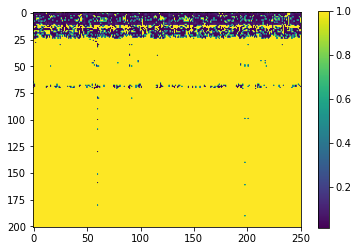

In [71]:
spectrogram = Spectrogram(n_fft = 400,
                          win_length = None, 
                          power = None,
                          normalized = True, 
                          return_complex = True)(torch.tensor(rnd_sample['Channel_1']).flatten()[:50000])

spectrogram[spectrogram.abs()<0.01]=1.

plt.imshow(spectrogram.abs())
plt.colorbar()

In [43]:
spectrogram.shape

torch.Size([1501, 1334])

In [52]:
class MATLAB_DS(Dataset):
    
    def __init__(self, data_dir, split_rate=1, transform=None):
        
        file_list = glob.glob(os.path.join(data_dir, '*.mat'))
        raw_items = [scipy.io.loadmat(file)['Channel_1'] for file in file_list]
        raw_labels = [file.split('/')[-1].split('-')[0] for file in file_list]
        label_mapping = {'H':0, 'I':1, 'O':2}
        raw_labels = [label_mapping[label] for label in raw_labels]
        
        self.items = []
        self.labels = []
        rate = 200000
        sample_length = rate//split_rate
        for item_idx, item in enumerate(raw_items):
            for i in range(10*split_rate):
                self.items.append(item[i*sample_length:(i+1)*sample_length])
                self.labels.append(raw_labels[item_idx])
            
        self.length = len(self.items)
        self.transform = transform
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        
        sample = (self.items[idx], self.labels[idx])
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

In [106]:
class ToTensor_onehot(object):
    """Convert sample to Tensors."""
    def __init__(self, n_classes=2):
        self.n_classes = n_classes

    def __call__(self, sample):
        x, y = sample
        y = np.eye(self.n_classes)[y]
        return ( torch.from_numpy(x.flatten()), torch.tensor(y) )
    
class Generate_Spectrograms(object):
    def __call__(self, sample):
        x, y = sample
        spectrogram = Spectrogram(n_fft = 800, 
                                  win_length = None, 
                                  power = None,
                                  normalized = True, 
                                  return_complex = True)(x)
        spectrogram = spectrogram.unsqueeze(0)
        return (spectrogram, y)

In [107]:
transform_to_spec = transforms.Compose([ToTensor_onehot(n_classes=3), Generate_Spectrograms()])

In [108]:
data_ds = MATLAB_DS('data/mendeley_data/data/', split_rate=1, transform=transform_to_spec)

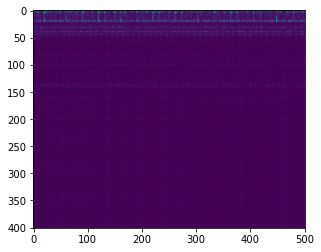

In [110]:
plt.imshow(np.abs(data_ds[0][0][0]))

In [57]:
data_ds.__len__()

360

In [115]:
train_ds, val_ds = torch.utils.data.random_split(data_ds, [270, 90])
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

## Classification Task

In [116]:
import jax
import jax.numpy as jnp
import haiku as hk

In [117]:
from complex_nn.layers import Cmplx_Conv2D, Cmplx_Linear, Dropout, CmplxBatchNorm
from complex_nn.optimizers import cmplx_adam
from complex_nn.activations import cardioid
from complex_nn.Classifier_wrapper import Haiku_Classifier
from complex_nn.utils import small_training_summary

In [118]:
class CVCNN(hk.Module):
    
    def __init__(self, n_classes=2):
        
        super().__init__()
        self.conv1 = Cmplx_Conv2D(2, kernel_shape=3, stride=2, data_format='NCHW')
        self.conv2 = Cmplx_Conv2D(4, kernel_shape=3, stride=2, data_format='NCHW')
        self.conv3 = Cmplx_Conv2D(8, kernel_shape=3, stride=2, data_format='NCHW')

        self.flatten = hk.Flatten()
        
        self.avg_pool = hk.AvgPool(window_shape=3, strides=2, padding='SAME', channel_axis=1)

        self.fc1 = Cmplx_Linear(8)
        self.fc2 = Cmplx_Linear(4)
        self.fc3 = Cmplx_Linear(2)
        self.fc4 = Cmplx_Linear(n_classes-1)

        self.dropout = Dropout(0.2)
        
        self.batchnorm_2D = CmplxBatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NCHW')
        self.batchnorm_1D = CmplxBatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NC')
        
        self.act = cardioid

    def __call__(self, z, is_training):
        z = self.act(self.conv1(z))
        z = self.batchnorm_2D(z, is_training)
        z = self.dropout(z, is_training)
        z = self.act(self.conv2(z))
        z = self.avg_pool(z)
        z = self.act(self.conv3(z))
        z = self.avg_pool(z)

        z = self.flatten(z)
        z = self.act(self.fc1(z))
        z = self.batchnorm_1D(z, is_training)
        z = self.dropout(z, is_training)
        z = self.act(self.fc2(z))

        healty_faulty = self.fc3(z)
        healty_out = jnp.expand_dims(healty_faulty[:,0], axis=-1)
        faulty_classification = jnp.expand_dims(healty_faulty[:,1], axis=-1)
        faulty_out = self.fc4(self.act(faulty_classification))

        out = jnp.concatenate([healty_out, faulty_out], axis=-1)
    
        return out

In [132]:
from importlib import reload
from complex_nn import Classifier_wrapper
reload(Classifier_wrapper)
from complex_nn.Classifier_wrapper import Haiku_Classifier

In [133]:
complex_hc4 = Haiku_Classifier()
_ = complex_hc4.train(n_epochs = 1, 
                     model = CVCNN, 
                     optimizer = cmplx_adam(step_size=1e-3),
                     train_dataloader = train_dl,
                     test_dataloader = val_dl,
                     verbose = False,
                     n_classes = 3)

/home/mattia/anaconda3/envs/jax_env/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3556: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


Training for several epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/17 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/6 [00:00<?, ?it/s]